<a href="https://colab.research.google.com/github/Soob00/20251R0136COSE47101/blob/dataset1/dataset1_clustered_decisiontrees_all_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

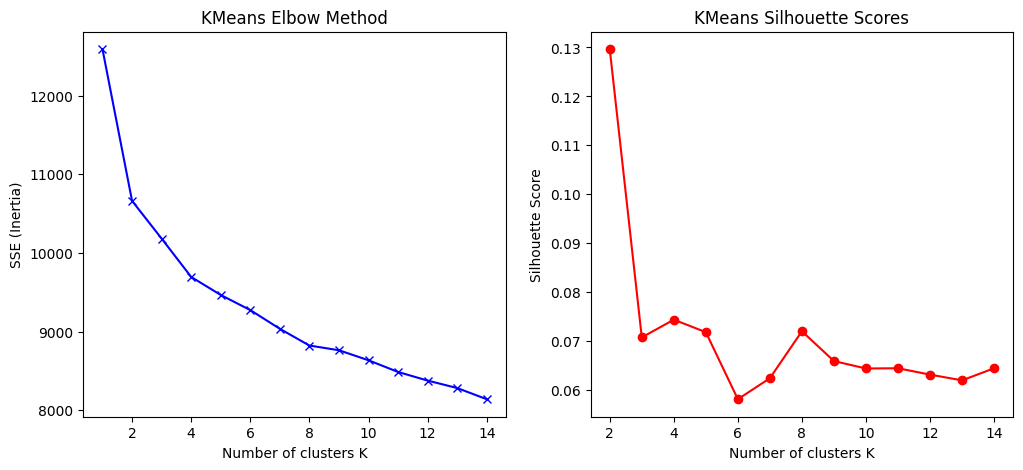

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import pandas as pd
df = pd.read_csv("/content/modified_processed_all_dataset1.csv")
X = df




# -------------------------
# 2. KMeans 하이퍼파라미터 튜닝
# -------------------------

sse = []
sil_scores = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    if k > 1:
        labels = kmeans.labels_
        sil_scores.append(silhouette_score(X, labels))
    else:
        sil_scores.append(np.nan)  # k=1은 실루엣 점수 계산 불가

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, sse, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('SSE (Inertia)')
plt.title('KMeans Elbow Method')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'ro-')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Scores')
plt.show()



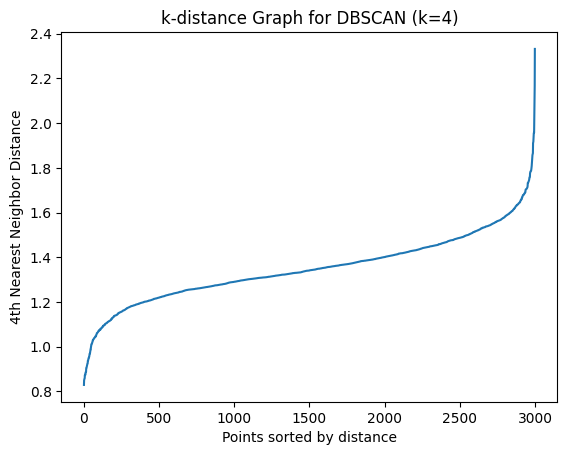

DBSCAN clusters found: 0


In [ ]:
# -------------------------
# 3. DBSCAN 하이퍼파라미터 튜닝
# -------------------------

# eps 결정 위해 k-distance 그래프 (min_samples=4 기준)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, 3])  # 4번째 이웃 거리
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (k=4)")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()

# 여기서 적당한 eps 범위 확인 후 예시로 eps=0.5 설정
dbscan = DBSCAN(eps=0.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(X)

# 클러스터 개수 (노이즈 제외)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN clusters found: {n_clusters_dbscan}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

'''
k=6
'''
# 1. KMeans 클러스터링
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# 클러스터별 샘플 수
print("KMeans 클러스터별 샘플 수:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

# 클러스터별 주요 특징 (평균, 분산)
kmeans_df = pd.DataFrame(X)
kmeans_df['cluster'] = kmeans_labels
print("KMeans 클러스터별 평균 및 분산:")
print(kmeans_df.groupby('cluster').agg(['mean', 'var']))

KMeans 클러스터별 샘플 수:
0    491
1    503
2    402
3    480
4    315
5    809
Name: count, dtype: int64
KMeans 클러스터별 평균 및 분산:
              Age           Exercise Level           Sleep Hours            \
             mean       var           mean       var        mean       var   
cluster                                                                      
0        0.509475  0.089982       0.497963  0.169384   -0.176533  0.137094   
1        0.503674  0.083335       0.471173  0.162016    1.283437  0.222929   
2        0.502866  0.086337       0.468905  0.162996   -0.966790  0.313728   
3        0.512183  0.080609       0.475000  0.162213   -1.287202  0.250902   
4        0.499724  0.081821       0.512698  0.170220    1.092091  0.270615   
5        0.501935  0.087459       0.504944  0.171386    0.128067  0.106557   

        Stress Level           Work Hours per Week            ...  \
                mean       var                mean       var  ...   
cluster                               

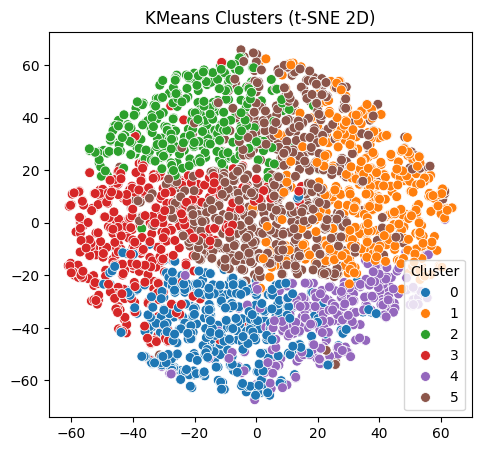

In [ ]:
# 4. 클러스터 시각화 (t-SNE)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette='tab10', s=50)
plt.title('KMeans Clusters (t-SNE 2D)')
plt.legend(title='Cluster')


plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels, method_name=""):
    """
    클러스터링 결과에 대한 내부 평가 지표를 계산하고 딕셔너리로 반환합니다.

    Parameters:
        X (ndarray): 클러스터링 대상 데이터 (scaling된 것)
        labels (ndarray): 클러스터링 결과 라벨
        method_name (str): 방법 이름 (예: "KMeans", "GMM", "DBSCAN")

    Returns:
        dict: method 이름과 내부 평가 지표들 (Silhouette, Calinski, Davies)
    """
    # 유효한 클러스터 개수 확인
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        # 클러스터가 1개 이하이면 평가할 수 없음
        return {
            "method": method_name,
            "n_clusters": n_clusters,
            "silhouette": None,
            "calinski": None,
            "davies": None
        }

    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)

    return {
        "method": method_name,
        "n_clusters": n_clusters,
        "silhouette": silhouette,
        "calinski": calinski,
        "davies": davies
    }


In [ ]:
results = []

# KMeans
results.append(evaluate_clustering(X, kmeans_labels, method_name="KMeans"))


# 결과를 데이터프레임으로 보기 좋게 정리
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df[["method", "n_clusters", "silhouette", "calinski", "davies"]]
results_df


,method,n_clusters,silhouette,calinski,davies
0,KMeans,6,0.058115,214.094123,3.080568


<ipython-input-7-3839571073>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


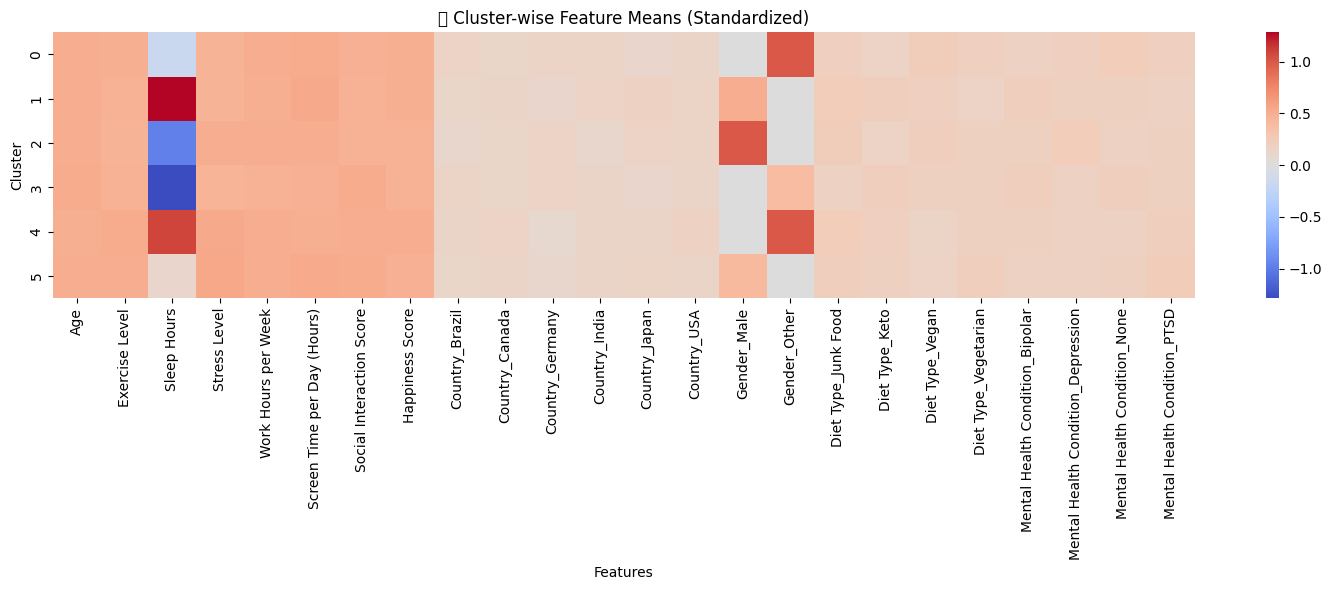

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터 번호가 담긴 Series 또는 배열을 가진 상태라고 가정 (예: kmeans_labels)
# 클러스터 결과를 데이터프레임에 추가
# feature_names를 정의 (X가 원래 DataFrame일 경우)
feature_names = X.columns

# 클러스터 결과 포함한 새로운 데이터프레임 만들기
clustered_df = pd.DataFrame(X, columns=feature_names)
clustered_df["cluster"] = kmeans_labels
clustered_df = pd.DataFrame(X, columns=feature_names)  # feature_names는 피처 이름 리스트
clustered_df["cluster"] = kmeans_labels  # KMeans 군집 결과

# 클러스터별 평균값 확인
cluster_means = clustered_df.groupby("cluster").mean()

# 히트맵으로 시각화
plt.figure(figsize=(15, 6))
sns.heatmap(cluster_means, cmap="coolwarm", center=0, annot=False)
plt.title("📊 Cluster-wise Feature Means (Standardized)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


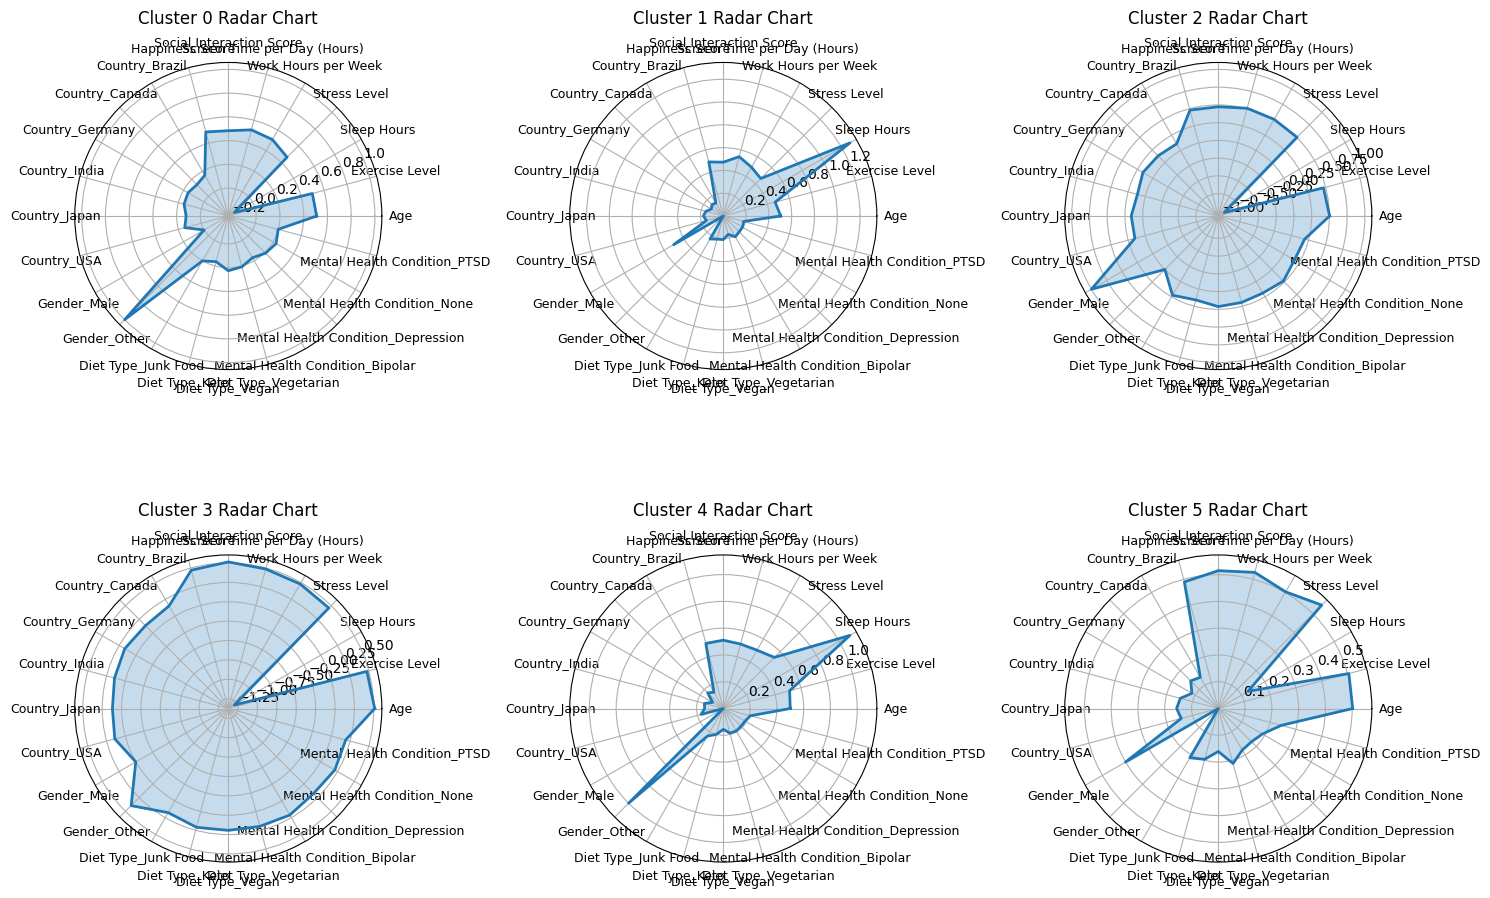

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 클러스터별 평균 계산
cluster_means = clustered_df.groupby("cluster").mean()

labels = cluster_means.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += [angles[0]]  # 닫기 위해 처음 각도 추가

num_clusters = len(cluster_means)
cols = 3  # 한 행에 3개씩 배치 (원하는 수로 변경 가능)
rows = (num_clusters + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), subplot_kw=dict(polar=True))
axs = axs.flatten()  # 1차원 배열로 만들어서 인덱싱 편하게

for i, (cluster_id, row) in enumerate(cluster_means.iterrows()):
    values = row.values
    values = np.concatenate((values, [values[0]]))  # 닫기 위해 처음값 추가

    ax = axs[i]
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f"Cluster {cluster_id} Radar Chart", y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)

# 남은 subplot은 삭제 (클러스터 수보다 많을 경우)
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
for cluster_id, data in clustered_df.groupby("cluster"):
    print(f"\nCluster {cluster_id} Summary:")
    print(data.describe().round(3))



Cluster 0 Summary:
           Age  Exercise Level  Sleep Hours  Stress Level  \
count  491.000         491.000      491.000       491.000   
mean     0.509           0.498       -0.177         0.465   
std      0.300           0.412        0.370         0.399   
min      0.000           0.000       -0.918         0.000   
25%      0.250           0.000       -0.451         0.000   
50%      0.478           0.500       -0.184         0.500   
75%      0.783           1.000        0.149         1.000   
max      1.000           1.000        0.550         1.000   

       Work Hours per Week  Screen Time per Day (Hours)  \
count              491.000                      491.000   
mean                 0.508                        0.516   
std                  0.295                        0.291   
min                  0.000                        0.000   
25%                  0.256                        0.267   
50%                  0.538                        0.533   
75%              

| 군집     | 주요 특성                                | 행복도            |
| ------ | ------------------------------------ | -------------- |
| **0번** | 낮은 수면 (최저 수준), 평균 운동량, 낮은 스트레스       | **0.498**      |
| **1번** | 수면 매우 높음, 평균 운동, 낮은 스트레스             | **0.491**      |
| **2번** | 수면 매우 부족, 평균 운동, 높은 스트레스             | **0.479**      |
| **3번** | 수면 최저 수준, 평균 운동, 스트레스 낮음             | **0.471**      |
| **4번** | 수면 많음, 운동량 높음, 스트레스 약간 높음            | **0.503** (최고) |
| **5번** | 평균 수면·운동, 스트레스 가장 높음, PTSD 비율도 가장 높음 | **0.490**      |


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

features = clustered_df.columns.drop(['Happiness Score', 'cluster'])

models_by_cluster = {}

for cluster_id in sorted(clustered_df['cluster'].unique()):
    cluster_data = clustered_df[clustered_df['cluster'] == cluster_id]
    X_cluster = cluster_data[features]
    y_cluster = cluster_data['Happiness Score']

    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n[Cluster {cluster_id}] Best Params: {grid_search.best_params_}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")

    models_by_cluster[cluster_id] = best_model


[Cluster 0] Best Params: {'max_depth': 3, 'min_samples_split': 2}
R² Score: -0.165
Mean Squared Error: 0.097

[Cluster 1] Best Params: {'max_depth': 3, 'min_samples_split': 2}
R² Score: -0.126
Mean Squared Error: 0.088

[Cluster 2] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: -0.204
Mean Squared Error: 0.099

[Cluster 3] Best Params: {'max_depth': 3, 'min_samples_split': 2}
R² Score: -0.212
Mean Squared Error: 0.098

[Cluster 4] Best Params: {'max_depth': 3, 'min_samples_split': 2}
R² Score: -0.079
Mean Squared Error: 0.068

[Cluster 5] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: -0.114
Mean Squared Error: 0.083
